# Univariate Time Series Prediction Using LSTM Recurrent Networks

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from pandas import Series
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from sklearn.preprocessing import MinMaxScaler

In [92]:
#One year data
data = pd.read_csv('D://T3.csv',parse_dates=True,index_col='Date/Time')
data=data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], freq='10T'))
data = data.ffill().bfill()

In [93]:
data.head()

,Wind Speed (m/s)
2018-01-01 00:00:00,5.311336
2018-01-01 00:10:00,5.672167
2018-01-01 00:20:00,5.216037
2018-01-01 00:30:00,5.659674
2018-01-01 00:40:00,5.577941


In [95]:
data.dtypes,len(data)

(Wind Speed (m/s)    float64
 dtype: object, 52560)

Text(0, 0.5, 'Wind Speed')

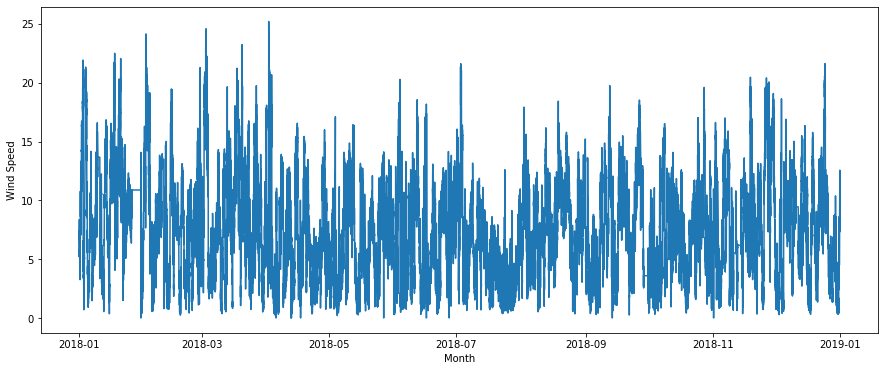

In [96]:
plt.plot(data)
plt.xlabel("Month")
plt.ylabel("Wind Speed")

## Train Set from January to September

## Test Set from October to December

 

In [97]:
# set seed
np.random.seed(3)

In [98]:
df=data.values

In [99]:
df = df.astype('float32')

In [100]:
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)

In [101]:
# slice the data
train = df[:38200]   #9 months data

In [102]:
test = df[38200:]     #3 months data


## Data Preparation

In [103]:
def prepare_data(data, lags=6):
    X, y = [], []
    for row in range(len(data) - lags - 1):
        a = data[row:(row + lags), 0]
        X.append(a)
        y.append(data[row + lags, 0])
    return np.array(X), np.array(y)  

In [104]:
# prepare the data
lags = 6
X_train, y_train = prepare_data(train, lags)
X_test, y_test = prepare_data(test, lags)
y_true = y_test     # due to naming convention

In [105]:
X_train.shape,y_train.shape

((38193, 6), (38193,))

In [106]:
X_test.shape,y_test.shape

((14353, 6), (14353,))

In [107]:
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 6, 1))
X_test = X_test.reshape((X_test.shape[0], 6, 1))

In [108]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((38193, 6, 1), (38193,), (14353, 6, 1), (14353,))

## Building a MLP model

In [109]:
from keras.models import Sequential
from keras.layers import Dense, LSTM


In [113]:
# create and fit Multilayer Perceptron model
mdl = Sequential()
mdl.add(LSTM(6,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
#model.add(LSTM(6, activation='relu',return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
mdl.add(LSTM(6,input_dim=lags, activation='relu'))
mdl.add(Dense(1))
mdl.compile(loss='mean_squared_error', optimizer='adam')
#fit network
history = mdl.fit( X_train,y_train,epochs=10, batch_size=70, validation_data=(X_test, y_test), verbose=2, shuffle=False)

#mdl.fit(X_train, y_train, epochs=200, batch_size=2, verbose=2)


C:\ProgramData\Anacondaa3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
C:\ProgramData\Anacondaa3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(6, activation="relu", input_shape=(None, 6))`
  """


Train on 38193 samples, validate on 14353 samples
Epoch 1/10
 - 6s - loss: 0.0376 - val_loss: 0.0085
Epoch 2/10
 - 5s - loss: 0.0054 - val_loss: 0.0051
Epoch 3/10
 - 5s - loss: 0.0050 - val_loss: 0.0043
Epoch 4/10
 - 5s - loss: 0.0045 - val_loss: 0.0037
Epoch 5/10
 - 5s - loss: 0.0039 - val_loss: 0.0031
Epoch 6/10
 - 5s - loss: 0.0033 - val_loss: 0.0025
Epoch 7/10
 - 5s - loss: 0.0027 - val_loss: 0.0023
Epoch 8/10
 - 5s - loss: 0.0026 - val_loss: 0.0023
Epoch 9/10
 - 5s - loss: 0.0025 - val_loss: 0.0022
Epoch 10/10
 - 5s - loss: 0.0024 - val_loss: 0.0021


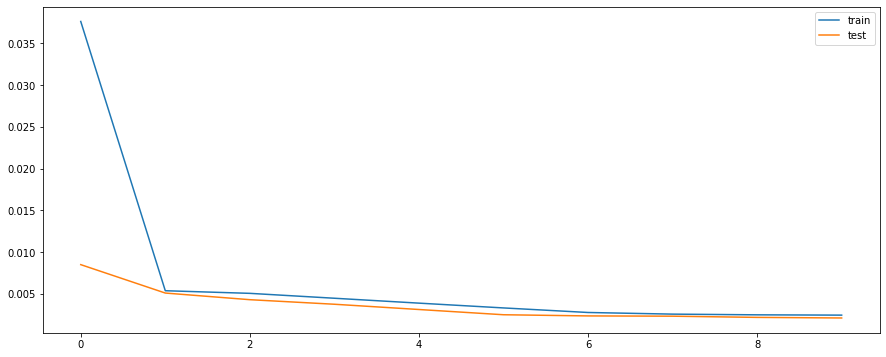

In [154]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


## Calculating MSE and RMSE

In [122]:
# estimate model performance
import math
train_score = mdl.evaluate(X_train, y_train, verbose=0)
print('Train Score:({:.5f} RMSE)'.format(math.sqrt(train_score)))
test_score = mdl.evaluate(X_test, y_test, verbose=0)
print('Test Score: ({:.2f} RMSE)'.format(math.sqrt(test_score)))

Train Score:(0.04830 RMSE)
Test Score: (0.05 RMSE)


In [123]:
# generate predictions for training
train_predict = mdl.predict(X_train)
test_predict = mdl.predict(X_test)

In [157]:
train_predict

array([[0.21181524],
       [0.21446937],
       [0.21355268],
       ...,
       [0.18274462],
       [0.18468508],
       [0.18460944]], dtype=float32)

In [124]:
# shift test predictions for plotting
test_predict_plot = np.empty_like(df)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(lags*2)+1:len(df)-1, :] = test_predict

In [125]:
# shift train predictions for plotting
train_predict_plot = np.empty_like(df)
train_predict_plot[:, :] = np.nan
train_predict_plot[lags: len(train_predict) + lags, :] = train_predict

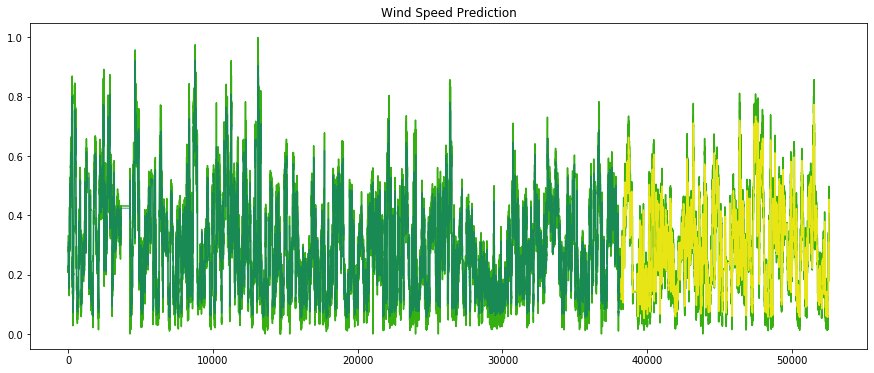

In [126]:
plt.plot(df, label='Observed', color='#35b010');
plt.plot(train_predict_plot, label='Prediction for Train Set', color='#006699', alpha=0.5);
plt.plot(test_predict_plot, label='Prediction for Test Set', color='#e8e515');
plt.title('Wind Speed Prediction')
plt.show()

In [87]:
#X_test.shape

In [88]:
#test_predict

In [134]:
#Rescaling the predicted values
inv_pred = scaler.inverse_transform(test_predict)
inv_pred 

array([[ 2.96604  ],
       [ 2.937338 ],
       [ 3.0742912],
       ...,
       [11.4457855],
       [11.097238 ],
       [10.398932 ]], dtype=float32)

In [135]:
test_inv=scaler.inverse_transform(test)
test_inv

array([[3.3349879],
       [2.868427 ],
       [2.500855 ],
       ...,
       [8.435358 ],
       [9.421366 ],
       [9.979332 ]], dtype=float32)

In [139]:
52560-38200

14360

In [140]:
#data[38200:38205]
c=pd.date_range('9/23/2018 06:40:00',periods=14360,freq='10T')
c=pd.DataFrame(c,columns=['index'])
actual_data=pd.DataFrame(test_inv,columns=['actual'])
pred_data=pd.DataFrame(inv_pred,columns=['pred'])
c['actual']=actual_data['actual']
c['pred']=pred_data['pred']

In [142]:
c=c.set_index('index')
c = c.ffill().bfill()
c.head()

,actual,pred
index,,
2018-09-23 06:40:00,3.334988,2.966040
2018-09-23 06:50:00,2.868427,2.937338
2018-09-23 07:00:00,2.500855,3.074291
2018-09-23 07:10:00,2.059041,3.370238
2018-09-23 07:20:00,2.810759,3.784001


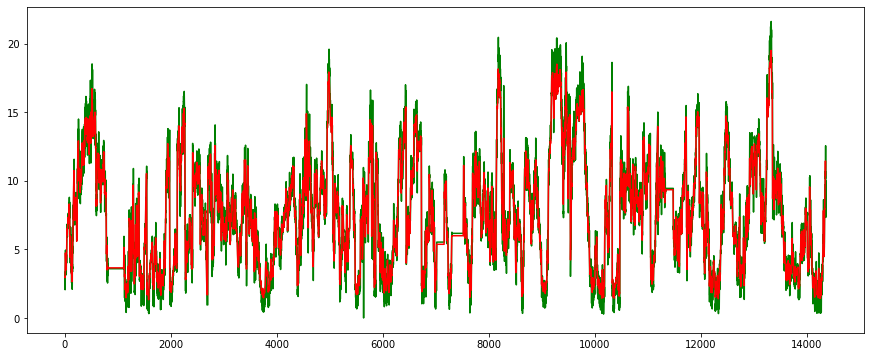

In [155]:
#plotting predicted Vs Actual Values
plt.plot(test_inv, color='green', label = 'Real Wind Speed')
plt.plot(inv_pred, color='red', label = 'Predicted Wind speed')
plt.show()

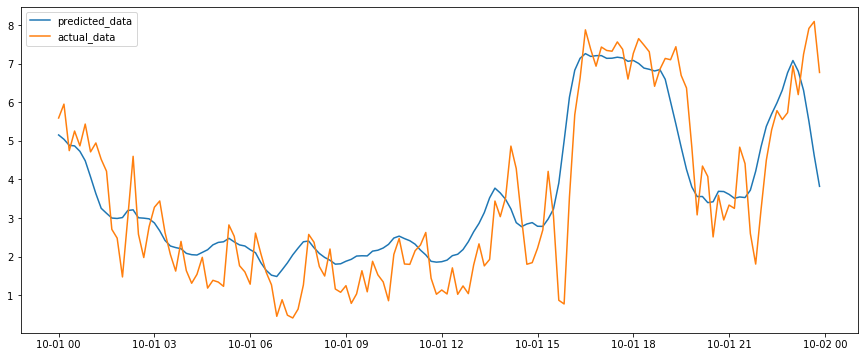

In [156]:
##plotting a single  day in the test set(3rd Nov)
plt.plot(c['pred']['2018-10-01'], label='predicted_data')
plt.plot(c['actual']['2018-10-01'], label='actual_data')
plt.legend()
plt.show()
